In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('makemore_dataset/things to eat.txt', 'r').read().lower().replace("'", '').replace('-', ' ').splitlines()
words[:8]

['turkeys',
 'pink beans',
 'half and half',
 'ice cream',
 'mushrooms',
 'aquavit',
 'cookies',
 'chives']

In [3]:
sorted(list(set(''.join(words))))

[' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [34]:
# map each character to an index for one-hot encoding
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

28

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([8085, 3]) torch.Size([8085])
torch.Size([1042, 3]) torch.Size([1042])
torch.Size([1017, 3]) torch.Size([1017])


#### Pytorch-API nn


In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
# g = torch.Generator().manual_seed(2147483647) # for reproducibility#
class Sequential:

  def __init__(self, layers, r_seed=2147483647):
    self.g = torch.Generator().manual_seed(r_seed) # for reproducibility
    self.layers = layers
    for layer in self.layers:
      self.g = r_seed

  def __call__(self, X):
    for layer in self.layers:
      X = layer(X)
    return X
  
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=self.g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

class Embedding:
  def __init__(self, n_embd = 10, vocab_size=28):
    self.C = torch.randn((vocab_size, n_embd), generator=self.g)
  def __call__(self, X):
      emb = self.C[X] # embed the characters into vectors
      self.out = emb.view(emb.shape[0], -1) # concatenate the vectors
      return self.out
  def parameters(self):
    return [v for v in self.C]
  
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [36]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

#C = torch.randn((vocab_size, n_embd),            generator=g)
model = Sequential(layers=[
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].gamma *= 0.1
  #model[-1].weight *= 0.1
  # all other model: apply gain
  for layer in model.layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

AttributeError: 'Linear' object has no attribute 'g'

In [ ]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []
ud = []

for layer in layers:
  layer.training = True

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = Sequential(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
    #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/   2000: 1.9090


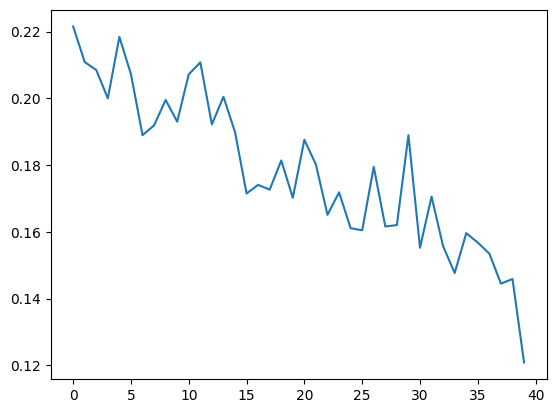

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 50).mean(dim=1));

In [22]:
for layer in layers:
    layer.training = False

#### Pytorch stats

layer 2 (      Tanh): mean +0.01, std 0.64, saturated: 5.00%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 5.12%
layer 8 (      Tanh): mean -0.00, std 0.66, saturated: 3.53%
layer 11 (      Tanh): mean -0.00, std 0.67, saturated: 2.97%
layer 14 (      Tanh): mean -0.01, std 0.67, saturated: 2.53%


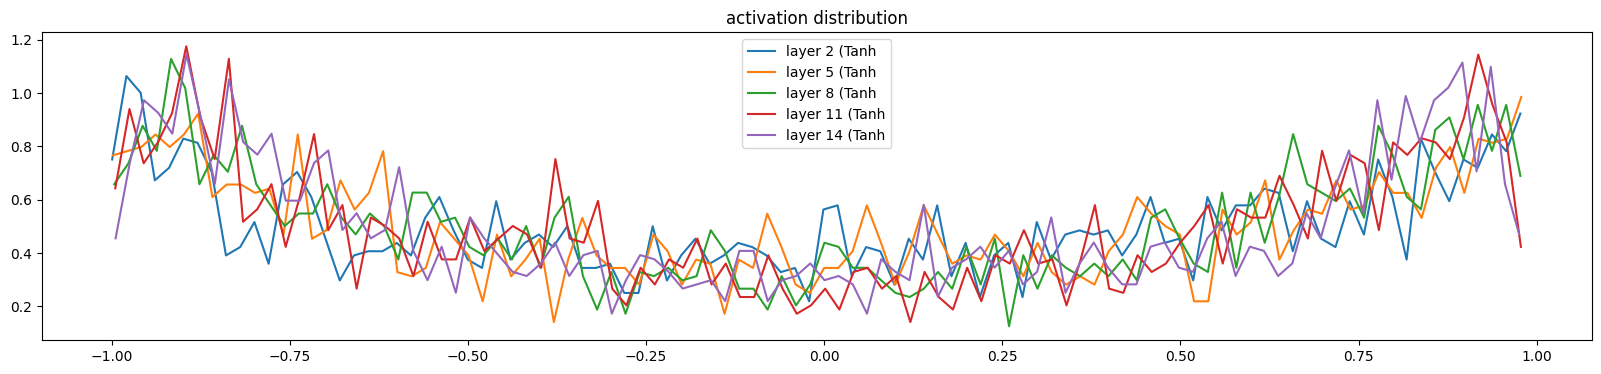

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.cpu()
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean -0.000000, std 5.186164e-03
layer 5 (      Tanh): mean +0.000000, std 4.736962e-03
layer 8 (      Tanh): mean +0.000000, std 4.837472e-03
layer 11 (      Tanh): mean +0.000000, std 4.455872e-03
layer 14 (      Tanh): mean -0.000000, std 3.995890e-03


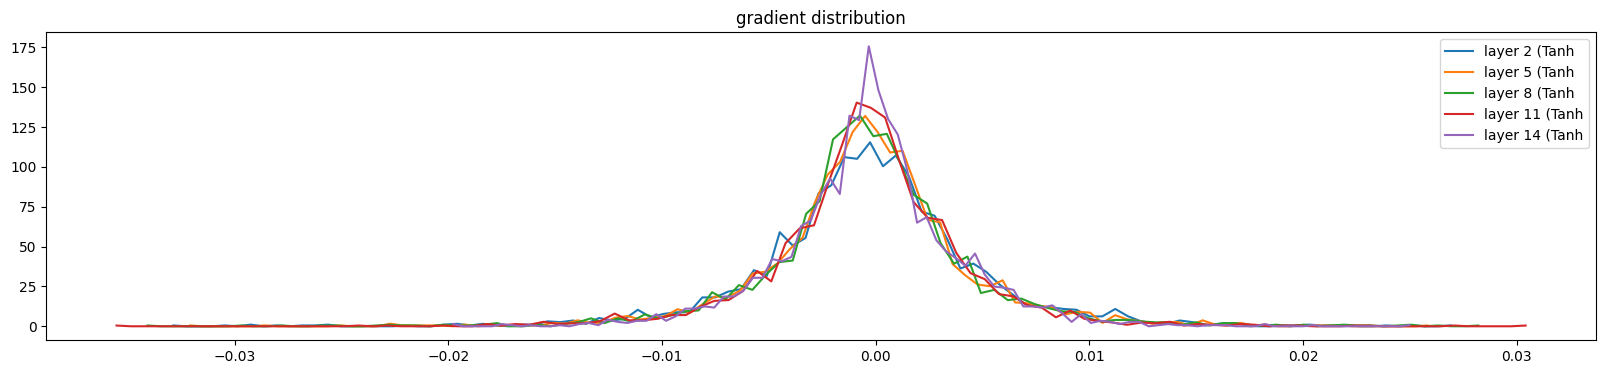

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad.cpu()
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (28, 10) | mean +0.000000 | std 1.480076e-02 | grad:data ratio 1.443512e-02
weight  (30, 100) | mean +0.000312 | std 2.224846e-02 | grad:data ratio 1.108022e-01
weight (100, 100) | mean +0.000145 | std 1.516074e-02 | grad:data ratio 1.318063e-01
weight (100, 100) | mean +0.000043 | std 1.440125e-02 | grad:data ratio 1.273985e-01
weight (100, 100) | mean +0.000046 | std 1.357013e-02 | grad:data ratio 1.215362e-01
weight (100, 100) | mean +0.000074 | std 1.130315e-02 | grad:data ratio 1.032424e-01
weight  (100, 28) | mean +0.000166 | std 1.992425e-02 | grad:data ratio 1.544563e-01


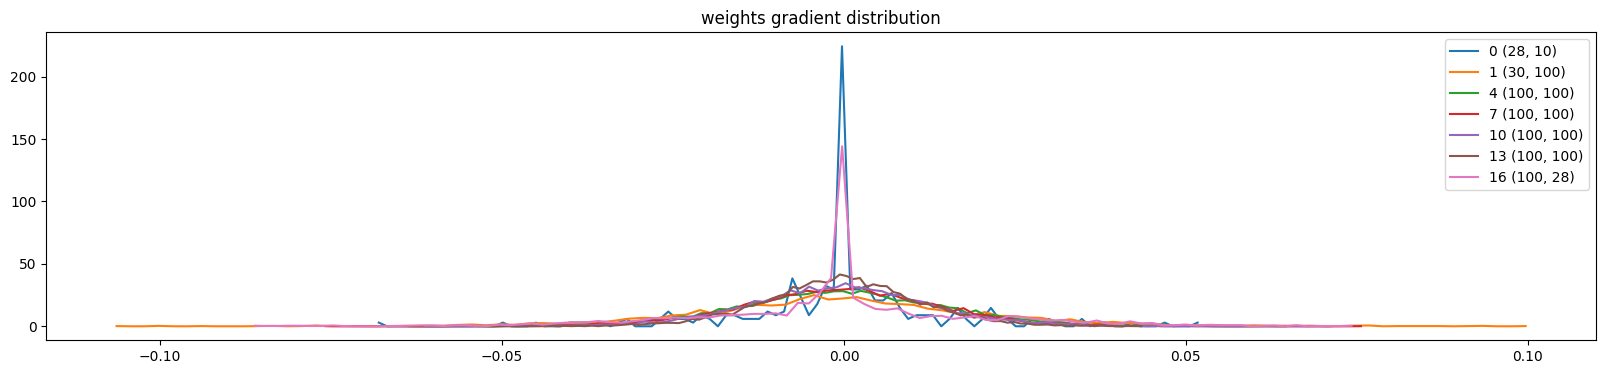

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad.cpu()
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

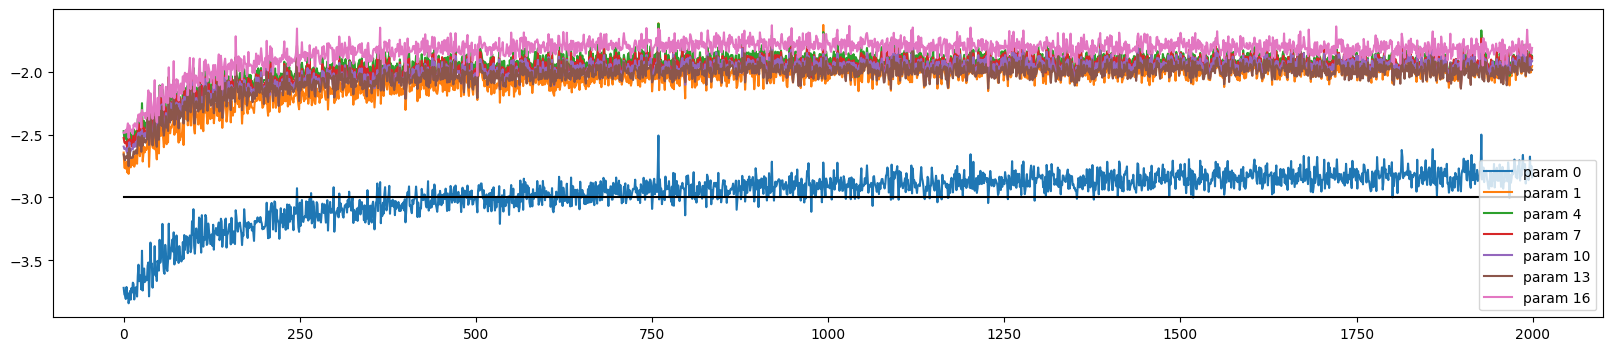

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1]).strip()) # decode and print the generated word

le peasauce
tegar
tumuettaichezfseeds
chinoty
coooo saudorapeferadins
blres
rica
cfegili sauce
dries
pinaguse
tard
broth
plumbs
gino  creamt
beans
almond nraise
caceste
dragusoiha
cels
plum nraicheese
cream lems
asiod shrooasheat
wuts
curry
worqtseri
white
curry
drea
tomatoecgigouilk
thi odo sauce
celese
heorifing
datisceak
onionions
pepper
libus
muck
turksread cheese
whece
andonione
blugsyblay fruit
chettonioniones
cog soda
tomegrout
brbhers
chili saum
custe
bragi
theyary
cheese


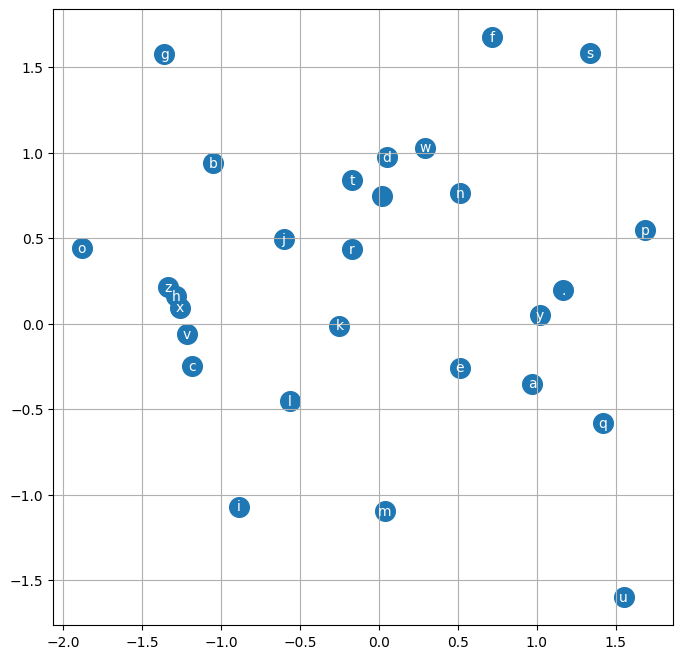

In [25]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].cpu().data, C[:,1].cpu().data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [18]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  X, Y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[X] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Y) # loss function

  print(split, loss.item())

In [26]:
# with batch normalising of initial loss and fixing saturated tanh
split_loss('train') # 2.24
split_loss('val') # 2.25

train 1.2825425863265991
val 1.6524832248687744
